In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

class Object(object): pass

# 3.1 Sampling from a grid-approximate posterior

#### 3.2

In [2]:
p_grid = np.linspace(0, 1, 1e3)
prior = np.ones(1000)
likelihood = stats.binom.pmf(n=9, k=6, p=p_grid)
posterior = likelihood * prior 
posterior /= posterior.sum()

Text(0.5,1,'Posterior')

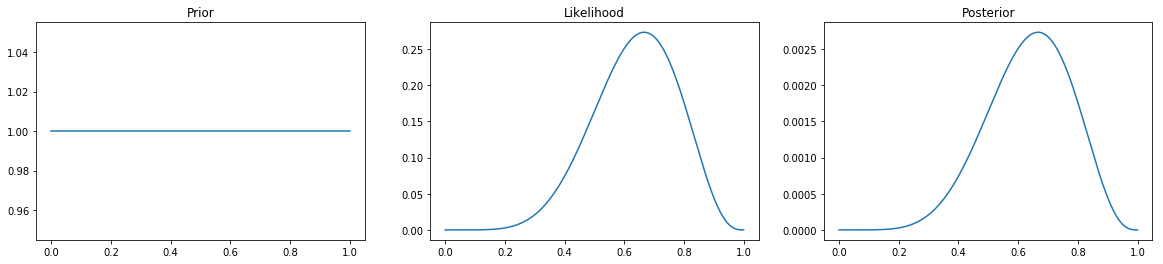

In [3]:
_32 = Object()
_32.fig, _32.ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
_32.ax[0].plot(p_grid, prior)
_32.ax[0].set_title("Prior")
_32.ax[1].plot(p_grid, likelihood)
_32.ax[1].set_title("Likelihood")
_32.ax[2].plot(p_grid, posterior)
_32.ax[2].set_title("Posterior")

#### 3.3

In [4]:
samples = np.random.choice(p_grid, size=int(1e3), p=posterior, replace=True)

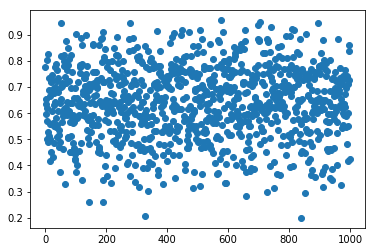

In [5]:
plt.plot(samples, marker="o", linestyle="none")

In [6]:
def dens(x, samples, smoothing_h=None):
    phi = lambda x: np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
    # Rule of thumb smoothing, see https://en.wikipedia.org/wiki/Kernel_density_estimation
    h = smoothing_h if smoothing_h is not None \
        else np.std(samples) * (4 / 3 / samples.shape[0])**(1/5)
    result = []
    for x_i in x:
        result.append(np.mean(phi((x_i - samples) / h)) / h)
    return np.array(result)

In [7]:
samples = np.random.choice(p_grid, size=int(1e5), p=posterior, replace=True)
density = dens(p_grid, samples)

Text(0.5,1,'Posterior')

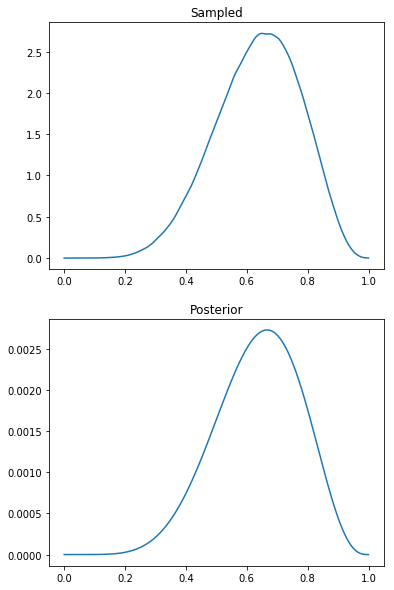

In [8]:
_33 = Object()
_33.fig, _33.ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
_33.ax[0].plot(p_grid, density)
_33.ax[0].set_title("Sampled")
_33.ax[1].plot(p_grid, posterior)
_33.ax[1].set_title("Posterior")</div><i class="fa fa-lightbulb-o "></i>

# 3.2. Sampling to summarize

What is the posterior P that water < 0.5 of the surface?

#### 3.6

In [9]:
# add up probabilities where p < 0.5
posterior[p_grid < 0.5].sum()

0.17187458902022873

#### 3.7

In [10]:
# E.g True, False, False, .... , False
samples_with_p_under_50 = samples < 0.5
number_of_sample_with_p_under_50 = samples_with_p_under_50.sum()

# Probability: # of samples with P < 0.5 / total # of samples
number_of_sample_with_p_under_50 / samples.shape[0]

0.172034

#### 3.8

In [11]:
((samples > 0.5) & (samples < 0.75)).sum() / samples.shape[0]

0.604915

In [12]:
def quantile(arr, perc_list):
    def single_quantile(arr, perc):
        k = (arr.shape[0] - 1) * perc
        f = np.floor(k)
        c = np.ceil(k)
        result = None
        if f == c:
            result = arr[int(k)]
        else:
            d0 = arr[int(f)] * (c - k)
            d1 = arr[int(c)] * (k - f)
            result = d0 + d1
        return result
    
    arr = np.sort(arr)
    
    if isinstance(perc_list, list):
        perc_list = np.array(perc_list)
        
    if isinstance(perc_list, np.ndarray):
        result = np.zeros_like(perc_list)
        for i, p in enumerate(perc_list):
            result[i] = single_quantile(arr, p)
    else:
        result = single_quantile(arr, perc_list)
    return result

#### 3.9

In [13]:
quantile(samples, 0.8)

0.7607607607607607

#### 3.10

In [14]:
quantile(samples, [0.1, 0.9])

array([0.44844845, 0.81281281])

#### 3.11

In [15]:
c32 = Object()
c32.p_grid = np.linspace(0, 1, 1000)
c32.prior = np.ones(c32.p_grid.shape[0])
c32.likelihood = stats.binom.pmf(n=3, k=3, p=c32.p_grid)
c32.posterior = c32.prior * c32.likelihood
c32.posterior /= c32.posterior.sum()
c32.samples = np.random.choice(
    c32.p_grid, 
    size=int(1e5), 
    replace=True, 
    p=c32.posterior)

In [16]:
c32.ret = quantile(c32.samples, [0.25, 0.75])
print(c32.ret)

[0.70770771 0.93093093]


In [31]:
import pymc3

c32.hpdi = pymc3.stats.hpd(c32.samples, 0.5)
c32.hpdi

array([0.84084084, 1.        ])

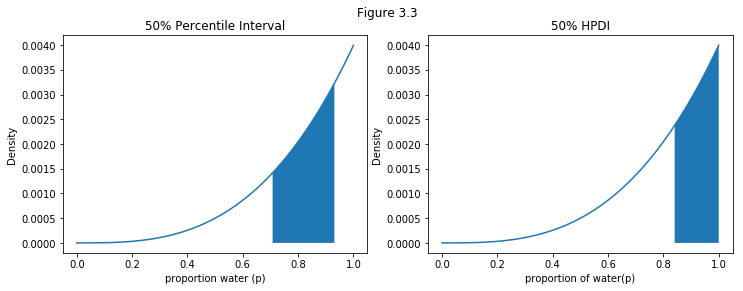

In [38]:
_311 = Object()
_311.indices = np.where(
      (c32.p_grid >= c32.ret[0]) 
    & (c32.p_grid <= c32.ret[1]))
_311.x = c32.p_grid[_311.indices]
_311.f = c32.posterior[_311.indices]

_311.fig, _311.ax = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)
_311.fig.suptitle("Figure 3.3")
_311.ax[0].plot(c32.p_grid, c32.posterior)
_311.ax[0].set_title("50% Percentile Interval")
_311.ax[0].set_xlabel("proportion water (p)")
_311.ax[0].set_ylabel("Density")
_311.ax[0].fill_between(_311.x, _311.f)

_311.ax[1].plot(c32.p_grid, c32.posterior)
_311.ax[1].set_title("50% HPDI")
_311.ax[1].set_xlabel("proportion of water(p)")
_311.ax[1].set_ylabel("Density")

_311.hpd_indices = np.where(
      (c32.p_grid >= c32.hpdi[0])
    & (c32.p_grid <= c32.hpdi[1]))
_311.ax[1].fill_between(
    c32.p_grid[_311.hpd_indices], 
    c32.posterior[_311.hpd_indices])

50% PI:   [0.54254254 0.74074074]
50% HPDI: [0.55255255 0.74774775]


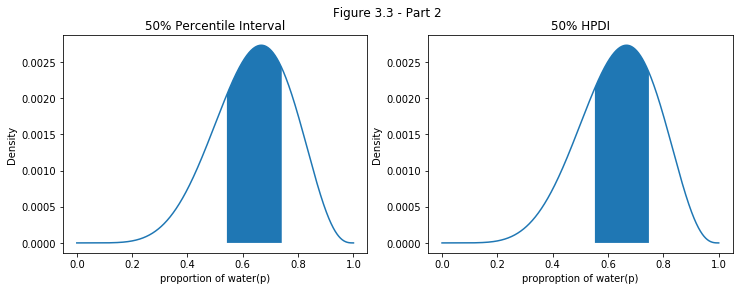

In [59]:
_ex = Object()
_ex.likelihood = stats.binom.pmf(n=9, k=6, p=c32.p_grid)
_ex.posterior = c32.prior * _ex.likelihood
_ex.posterior /= _ex.posterior.sum()
_ex.samples = np.random.choice(
    c32.p_grid,
    size=10000,
    replace=True,
    p=_ex.posterior
)
_ex.pi = quantile(_ex.samples, [0.25, 0.75])
_ex.hpdi = pymc3.stats.hpd(_ex.samples, 0.5)

_ex.fig, _ex.ax = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)
_ex.fig.suptitle("Figure 3.3 - Part 2")
_ex.ax[0].set_title("50% Percentile Interval")
_ex.ax[0].set_xlabel("proportion of water(p)")
_ex.ax[0].set_ylabel("Density")
_ex.ax[0].plot(c32.p_grid, _ex.posterior)
_ex.pi_indices = np.where(
      (c32.p_grid >= _ex.pi[0])
    & (c32.p_grid <= _ex.pi[1]))
_ex.pi_x = c32.p_grid[_ex.pi_indices]
_ex.pi_f = _ex.posterior[_ex.pi_indices]
_ex.ax[0].fill_between(_ex.pi_x, _ex.pi_f)

_ex.ax[1].set_title("50% HPDI")
_ex.ax[1].set_xlabel("proproption of water(p)")
_ex.ax[1].set_ylabel("Density")
_ex.ax[1].plot(c32.p_grid, _ex.posterior)
_ex.hpd_indices = np.where(
      (c32.p_grid >= _ex.hpdi[0])
    & (c32.p_grid <= _ex.hpdi[1]))
_ex.hpd_x = c32.p_grid[_ex.hpd_indices]
_ex.hpd_f = _ex.posterior[_ex.hpd_indices]
_ex.ax[1].fill_between(_ex.hpd_x, _ex.hpd_f)

print("50% PI:  ", _ex.pi)
print("50% HPDI:", _ex.hpdi)